<a href="https://colab.research.google.com/github/aymanred121/handwritten-signature-recognition/blob/main/Model/Siamese_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
import random
import cv2
import tensorflow as tf
import time
import random
from pathlib import Path

from tensorflow.keras import datasets, layers, models,applications,losses,optimizers,metrics,Model,backend

from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import resnet,Xception

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Conv2D,Dropout,Flatten

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

tf.__version__, np.__version__
target_shape = (200, 200)

In [ ]:
!rm -rf /content/*

In [ ]:
!gdown 1WqIhqp9JJ65SZPs9v868P_-SBCVTR2By

Downloading...
From: https://drive.google.com/uc?id=1WqIhqp9JJ65SZPs9v868P_-SBCVTR2By
To: /content/CV_2023_SC_Dataset.zip
100% 1.20M/1.20M [00:00<00:00, 149MB/s]


In [ ]:
!unzip /content/CV_2023_SC_Dataset.zip -d /content/data

Making every train and test together 

In [ ]:
import os
persons = ['A','B','C','D','E']
os.mkdir('/content/Train')
os.mkdir('/content/Test')
for p in persons:
    os.mkdir('/content/Train/person'+p)
    os.mkdir('/content/Test/person'+p)
    

In [ ]:
import shutil
import os
import glob
for p in os.listdir('data'):
  print(p)
  for f in os.listdir(f'data/{p}'):
    for d in glob.glob(f'/content/data/{p}/{f}/*'):
      shutil.move(d,f'/content/{f}/{p}')

personC
personB
personA
personD
personE


Putting DataFrames together

In [ ]:
persons = ['A','B','C','D','E']
df = pd.DataFrame()
for person in  persons:
  path = f'/content/Train/person{person}/person{person}_SigVerificationTrainLabels.csv'
  tempdf = pd.read_csv(path)
  tempdf['person'] = person
  df = df.append(tempdf)

In [ ]:
df.head()

,image_name,label,person
0,personA_37.png,forged,A
1,personA_3.png,forged,A
2,personA_28.png,forged,A
3,personA_31.png,forged,A
4,personA_48.png,forged,A


In [ ]:
forged = []
real = []
tripletList = []
forged = df[df["label"]=="forged"]
real = df[df.label=="real"]

In [ ]:
forged.head()

,image_name,label,person
0,personA_37.png,forged,A
1,personA_3.png,forged,A
2,personA_28.png,forged,A
3,personA_31.png,forged,A
4,personA_48.png,forged,A


In [ ]:
def create_triplets(real,fake, max_files=10):
    triplets = []
    a = 0
    for person in real["person"].unique():
      for i in range(len(real[real["person"]==person])-1):
        if(person!=0):
          print(i+a)
        for j in range(i+1,len(real[real["person"]==person])):
            anchor = real.iloc[(i+a)%(len(real)-1)]["image_name"]
            positive = real.iloc[(j+a)%(len(real)-1)]["image_name"]
            negative = fake.iloc[(j+a)%(len(real)-1)]["image_name"]    
            triplets.append((anchor,positive,negative))
      a = a+40
            
    random.shuffle(triplets)
    return triplets

In [ ]:
trip = create_triplets(real,forged)

In [ ]:
trip[45]

('personA_4.png', 'personA_17.png', 'personA_11.png')

put all images together

In [ ]:
os.mkdir('/content/allImages')

In [ ]:
for p in os.listdir('Test'):
  print(p)
  for d in glob.glob(f'/content/Train/{p}/*.png'):
    shutil.copy(d,f'/content/allImages')

personC
personB
personA
personD
personE


In [ ]:
for p in os.listdir('Test'):
  print(p)
  for d in glob.glob(f'/content/Test/{p}/*.png'):
    shutil.copy(d,f'/content/allImages')

personC
personB
personA
personD
personE


In [ ]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_png(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [ ]:
anchorImages = []
positiveImages = []
negativeImages = []
tripImages = []
for images in trip:
  tripImages.append(preprocess_triplets("/content/allImages/"+images[0],"/content/allImages/"+images[1],"/content/allImages/"+images[2]))

for images in tripImages:
  anchorImages.append(images[0])
  positiveImages.append(images[1])
  negativeImages.append(images[2])

In [ ]:
anchorImages[0][2]==anchorImages[0][3]

In [ ]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchorImages)
positive_dataset = tf.data.Dataset.from_tensor_slices(positiveImages)
negative_dataset = tf.data.Dataset.from_tensor_slices(negativeImages)
#negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
#dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(len(anchorImages) * 0.8))
val_dataset = dataset.skip(round(len(anchorImages) * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

In [ ]:
print(dataset)

<ShuffleDataset element_spec=(TensorSpec(shape=(200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(200, 200, 3), dtype=tf.float32, name=None))>


In [ ]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])




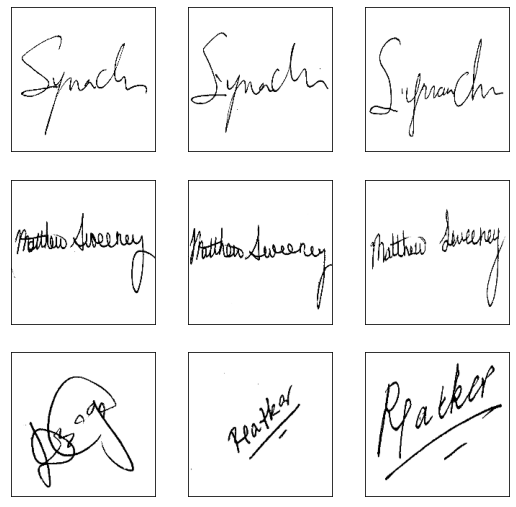

In [ ]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

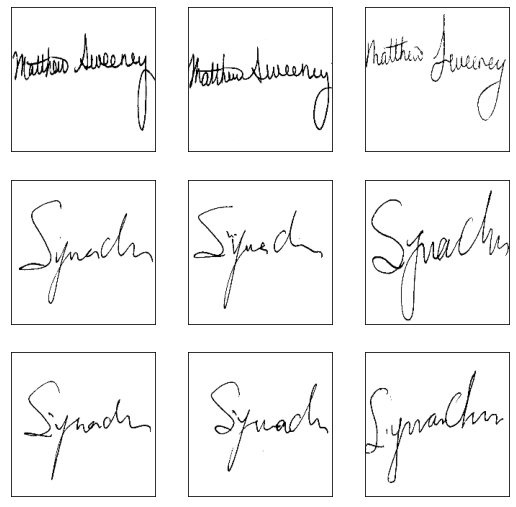

In [ ]:
visualize(anchorImages[0:3],positiveImages[0:3],negativeImages[0:3])

Setting up the embedding generator model (encoder)

In [ ]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")
# for transfer learning we make the first layers weights untrianable except the last layer 
# which is Conv5 in resnet doc (https://arxiv.org/pdf/1512.03385.pdf)
trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

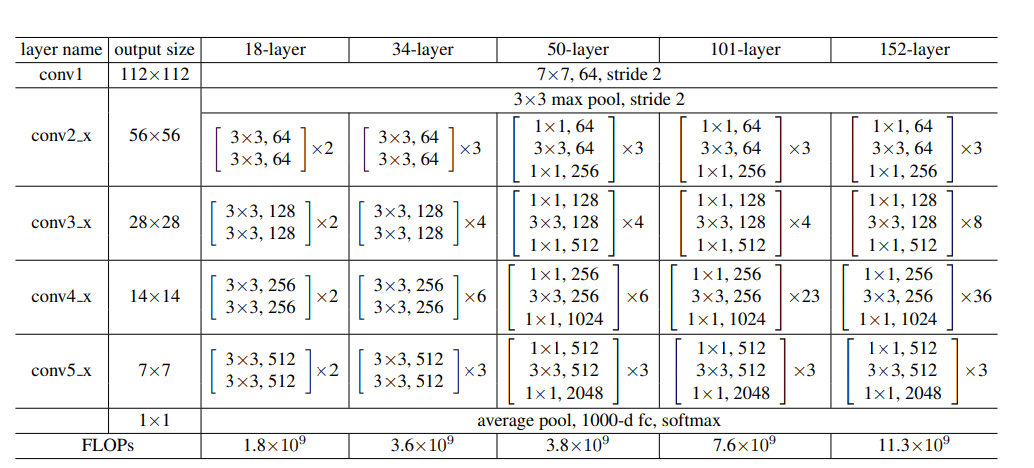

# Setting up the Siamese Network model
The Siamese network will receive each of the triplet images as an input, generate the embeddings, and output the distance between the anchor and the positive embedding, as well as the distance between the anchor and the negative embedding.

To compute the distance, we can use a custom layer DistanceLayer that returns both values as a tuple.

In [80]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


In [ ]:
anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances)

We now need to implement a model with custom training loop so we can compute the triplet loss using the three embeddings produced by the Siamese network.

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))

In [ ]:
siamese_model.fit(train_dataset,epochs=10,validation_data=val_dataset)

Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.1567

24/24 [==============================] - 22s 534ms/step - loss: 0.1567 - val_loss: 0.0323
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.0750

24/24 [==============================] - 9s 396ms/step - loss: 0.0750 - val_loss: 0.2041
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.0487

24/24 [==============================] - 10s 401ms/step - loss: 0.0487 - val_loss: 0.0100
Epoch 4/10
24/24 [==============================] - ETA: 0s - loss: 0.0070

24/24 [==============================] - 10s 402ms/step - loss: 0.0070 - val_loss: 0.0049
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 2.8318e-04

24/24 [==============================] - 10s 406ms/step - loss: 2.8318e-04 - val_loss: 0.0045
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.0017

24/24 [==============================] - 10s 408ms/step - loss: 0.0017 - val_loss: 0.0095
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 4.4359e-04

24/24 [==============================] - 10s 411ms/step - loss: 4.4359e-04 - val_loss: 0.0000e+00
Epoch 8/10
24/24 [==============================] - ETA: 0s - loss: 2.9783e-04

24/24 [==============================] - 10s 409ms/step - loss: 2.9783e-04 - val_loss: 0.0000e+00
Epoch 9/10
24/24 [==============================] - ETA: 0s - loss: 0.0000e+00

24/24 [==============================] - 10s 407ms/step - loss: 0.0000e+00 - val_loss: 0.0150
Epoch 10/10
24/24 [==============================] - ETA: 0s - loss: 0.0180

24/24 [==============================] - 10s 406ms/step - loss: 0.0180 - val_loss: 0.0000e+00


In [ ]:
anchorImages[0].shape

TensorShape([200, 200, 3])

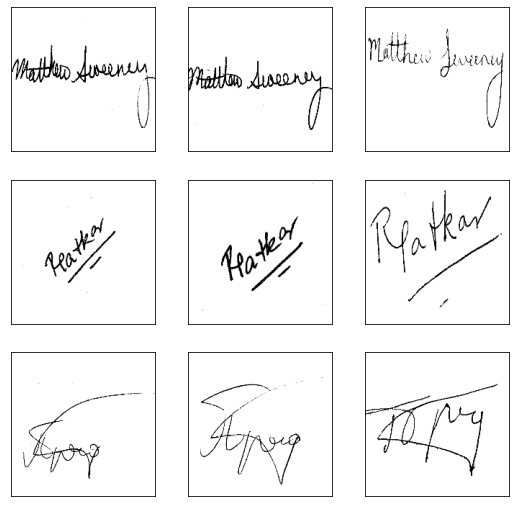

In [ ]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [ ]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.99592084
Negative similarity 0.9813816


In [84]:
siamese_model.predict((anchorImages[0],positiveImages[0],negativeImages[0]))

ValueError: ignored